In [1]:
## Using unsloth VL model

In [5]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch
from PIL import Image

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth


In [2]:

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen3-VL-8B-Instruct-unsloth-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.11.3: Fast Qwen3_Vl patching. Transformers: 4.57.1.
   \\   /|    NVIDIA GeForce RTX 3060. Num GPUs = 1. Max memory: 11.622 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

In [11]:
FastVisionModel.for_inference(model) # Enable for inference!

image = Image.open("../imgs/example_darkmod.png")

# --- THE SYSTEM PROMPT (The "Brain" Context) ---
# This tells Qwen how to play the game.
system_prompt = """You are an elite stealth agent playing 'The Dark Mod'.
Your goal is to navigate the level, steal loot, and avoid detection.

CONTROLS YOU CAN USE:
- 'w': Move Forward
- 's': Move Backward
- 'a': Strafe Left
- 'd': Strafe Right
- 'c': Toggle Crouch (Use this when the Light Gem is bright/white)
- 'space': Jump / Mantle
- 'enter': Interact / Open Door / Pick up Loot

HUD GUIDE:
- Bottom Center Icon: Light Gem.
  * Dark/Black = You are hidden (Safe).
  * Bright/White = You are visible (Danger).
- Red Bar: Health.
- Compass: Direction.

OUTPUT FORMAT:
Always reason first, then pick an action.
Example: "I am in a bright hallway. I see a guard ahead. I should crouch to stay hidden. Action: c"
"""

instruction = "Analyze the current game state and decide the next move."

messages = [
    # 1. The System Prompt (Context)
    {"role": "system", "content": system_prompt},
    
    # 2. The User Input (The current frame)
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

# ... rest of your generation code ...

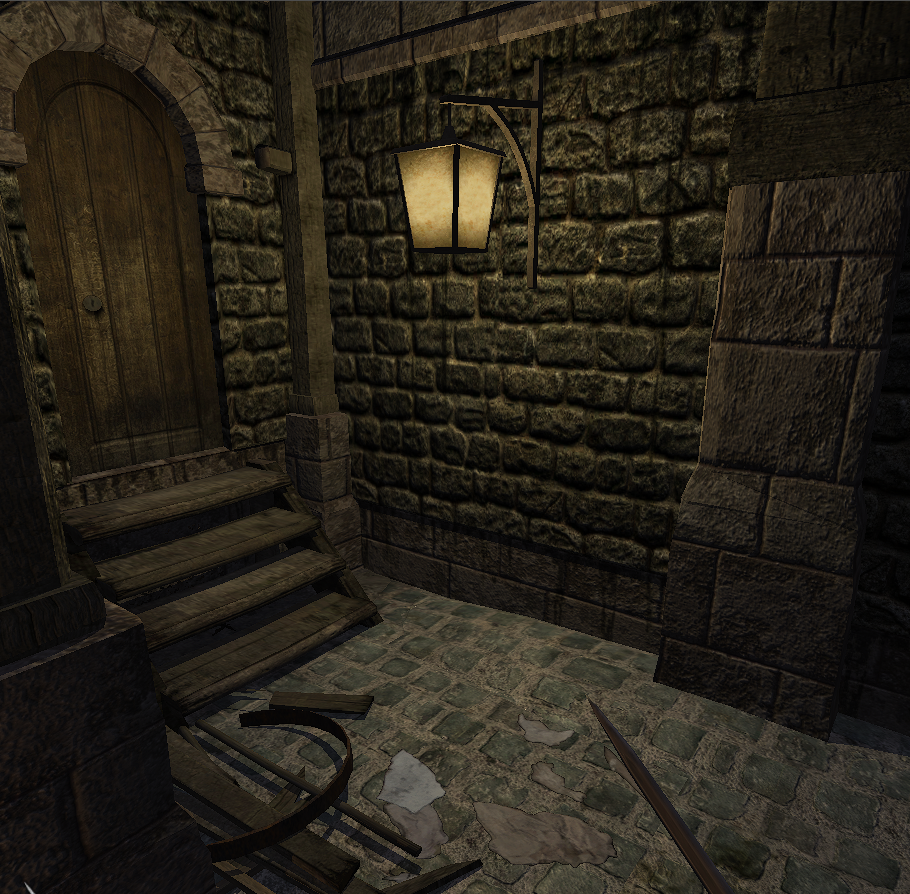

In [12]:
image

In [13]:
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

I am in a dimly lit stone corridor with a lantern hanging on the wall. The Light Gem is dark, indicating I'm hidden. There's a wooden door ahead and debris on the floor. I should investigate the door to see if it's a potential path forward or contains loot.

Action: enter<|im_end|>
